## Import libraries

### Run on colab
%cd /content    
!git clone https://github.com/Giovannicus/GourmetAI.git     
%cd GourmetAI   
!git checkout test_exp_to_module

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

import matplotlib.pyplot as plt
import numpy as np
import os

import albumentations as A
from albumentations.pytorch import ToTensorV2

import seaborn as sns
from src import *
import torchsummary

import logging
import time
import shutil
import sys
from pathlib import Path

from IPython.display import clear_output

## Data preprocessing

In [5]:
download_and_unzip("https://proai-datasets.s3.eu-west-3.amazonaws.com/dataset_food_classification.zip")

I file sono stati estratti in: C:\Users\gcusumano\ProfAI\GourmetAI


In [2]:
class Transforms:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img, *args, **kwargs):
        return self.transforms(image=np.array(img))['image']

transform = A.Compose([
        A.Resize(224, 224),
        A.HorizontalFlip(),
        A.VerticalFlip(),
        A.Rotate(limit=20),
        A.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ToTensorV2(),
      ])

In [3]:
trainset = torchvision.datasets.ImageFolder(root='dataset/train', transform=Transforms(transform))

valset = torchvision.datasets.ImageFolder(root='dataset/val', transform=Transforms(transform))

testset = torchvision.datasets.ImageFolder(root='dataset/test',transform=Transforms(transform))

In [4]:
len(trainset), len(valset), len(testset)

(8960, 2240, 2800)

In [17]:
batch_size = 32
num_batches = 2
from torch.utils.data import Subset
num_samples = num_batches * batch_size
subset_indices = list(range(num_samples)) 
limited_trainset = Subset(trainset, subset_indices)
limited_valset = Subset(valset, subset_indices)
limited_testset = Subset(testset, subset_indices)

trainloader = torch.utils.data.DataLoader(limited_trainset, batch_size=batch_size,
                                          shuffle=True)
valloader = torch.utils.data.DataLoader(limited_valset, batch_size=batch_size,
                                          shuffle=False)

testloader = torch.utils.data.DataLoader(limited_testset, batch_size=batch_size,
                                         shuffle=False)

## Transfer Learning

In [19]:
torch.cuda.empty_cache()
vgg = models.vgg16(pretrained=True)

for param in vgg.parameters():
    param.requires_grad = False

last_layer = vgg.classifier[-1]
last_layer_n_features = last_layer.in_features
classes = trainset.classes
vgg.classifier[-1] = nn.Linear(last_layer_n_features, len(classes))
torchsummary.summary(vgg,(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

## Training options

### logger + exp

In [12]:
import numpy as np
import os
import torch
import shutil
import sys
from pathlib import Path
import matplotlib.pyplot as plt
import logging
import importlib

def get_logger(ch_log_level=logging.ERROR, 
               fh_log_level=logging.INFO):
    logging.shutdown()
    importlib.reload(logging)  # Sostituito imp.reload con importlib.reload
    logger = logging.getLogger("cheatsheet")
    logger.setLevel(logging.DEBUG)
    
    # Console Handler
    if ch_log_level:
        ch = logging.StreamHandler()
        ch.setLevel(ch_log_level)
        ch.setFormatter(logging.Formatter('%(message)s'))
        logger.addHandler(ch)
    
    # File Handler
    if fh_log_level:
        fh = logging.FileHandler('cheatsheet.log')
        fh.setLevel(fh_log_level)
        formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
        fh.setFormatter(formatter)
        logger.addHandler(fh)

    return logger

class Experiment():
    def __init__(self, name, root, logger=None):
        self.name = name
        self.root = os.path.join(root, name)
        self.logger = logger
        self.epoch = 1
        self.best_val_loss = sys.maxsize
        self.best_val_loss_epoch = 1
        self.weights_dir = os.path.join(self.root, 'weights')
        self.history_dir = os.path.join(self.root, 'history')
        self.results_dir = os.path.join(self.root, 'results')
        self.latest_weights = os.path.join(self.weights_dir, 'latest_weights.pth')
        self.latest_optimizer = os.path.join(self.weights_dir, 'latest_optim.pth')
        self.best_weights_path = self.latest_weights
        self.best_optimizer_path = self.latest_optimizer
        self.train_history_fpath = os.path.join(self.history_dir, 'train.csv')
        self.val_history_fpath = os.path.join(self.history_dir, 'val.csv')
        self.test_history_fpath = os.path.join(self.history_dir, 'test.csv')
        self.loss_history = {
            'train': np.array([]),
            'val': np.array([]),
            'test': np.array([])
        }
        self.precision_history = { 
            'train': np.array([]),
            'val': np.array([]),
            'test': np.array([])
        }
        
    def log(self, msg):
        if self.logger:
            self.logger.info(msg)
        
    def init(self):
        self.log("Creating new experiment")
        self.init_dirs()
        self.init_history_files()

    def resume(self, model, optim, weights_fpath=None, optim_path=None):
        self.log("Resuming existing experiment")
        if weights_fpath is None:
            weights_fpath = self.latest_weights
        if optim_path is None:
            optim_path = self.latest_optimizer

        model, state = self.load_weights(model, weights_fpath)
        optim = self.load_optimizer(optim, optim_path)

        self.best_val_loss = state['best_val_loss']
        self.best_val_loss_epoch = state['best_val_loss_epoch']
        self.epoch = state['last_epoch'] + 1
        self.load_history_from_file('train')
        self.load_history_from_file('val')

        return model, optim

    def init_dirs(self):
        os.makedirs(self.weights_dir, exist_ok=True)
        os.makedirs(self.history_dir, exist_ok=True)
        os.makedirs(self.results_dir, exist_ok=True)
        
    def init_history_files(self):
        Path(self.train_history_fpath).touch()
        Path(self.val_history_fpath).touch()
        Path(self.test_history_fpath).touch()

   
    def load_history_from_file(self, dset_type):
        fpath = os.path.join(self.history_dir, dset_type + '.csv')
        try:
            data = np.loadtxt(fpath, delimiter=',').reshape(-1, 3)
            self.loss_history[dset_type] = data[:, 1]
            self.precision_history[dset_type] = data[:, 2] 
        except:
            self.loss_history[dset_type] = np.array([])
            self.precision_history[dset_type] = np.array([])  


    def append_history_to_file(self, dset_type, loss, precision):
        fpath = os.path.join(self.history_dir, dset_type + '.csv')
        with open(fpath, 'a') as f:
            f.write('{},{},{}\n'.format(self.epoch, loss, precision))

    def save_history(self, dset_type, loss, precision): 
        self.loss_history[dset_type] = np.append(self.loss_history[dset_type], loss)
        self.precision_history[dset_type] = np.append(self.precision_history[dset_type], precision)  
        self.append_history_to_file(dset_type, loss, precision)  

        if dset_type == 'val' and self.is_best_loss(loss):
            self.best_val_loss = loss
            self.best_val_loss_epoch = self.epoch
            
        if dset_type == 'val':
            self.plot_and_save_history()

    def is_best_loss(self, loss):
        return loss < self.best_val_loss

    def save_weights(self, model, trn_loss, val_loss, trn_precison, val_precision):
        weights_fname = self.name + '-weights-%d-%.3f-%.3f-%.3f-%.3f.pth' % (
            self.epoch, trn_loss, trn_precision, val_loss, val_precision)
        weights_fpath = os.path.join(self.weights_dir, weights_fname)
        torch.save({
            'last_epoch': self.epoch,
            'trn_loss': trn_loss,
            'val_loss': val_loss,
            'trn_precision': trn_precision,
            'val_precision': val_precision,
            'best_val_loss': self.best_val_loss,
            'best_val_loss_epoch': self.best_val_loss_epoch,
            'experiment': self.name,
            'state_dict': model.state_dict()
        }, weights_fpath)
        shutil.copyfile(weights_fpath, self.latest_weights)
        if self.is_best_loss(val_loss):
            self.best_weights_path = weights_fpath

    def load_weights(self, model, fpath):
        self.log("loading weights '{}'".format(fpath))
        state = torch.load(fpath)
        model.load_state_dict(state['state_dict'])
        self.log("loaded weights from experiment %s (last_epoch %d, trn_loss %s, trn_precision %s, val_loss %s, val_precision %s)" % (
            self.name, state['last_epoch'], state['trn_loss'],
            state['trn_precision'], state['val_loss'], state['val_precision']))
        return model, state

    def save_optimizer(self, optimizer, val_loss):
        optim_fname = self.name + '-optim-%d.pth' % (self.epoch)
        optim_fpath = os.path.join(self.weights_dir, optim_fname)
        torch.save({
            'last_epoch': self.epoch,
            'experiment': self.name,
            'state_dict': optimizer.state_dict()
        }, optim_fpath)
        shutil.copyfile(optim_fpath, self.latest_optimizer)
        if self.is_best_loss(val_loss):
            self.best_optimizer_path = optim_fpath

    def load_optimizer(self, optimizer, fpath):
        self.log("loading optimizer '{}'".format(fpath))
        optim = torch.load(fpath)
        optimizer.load_state_dict(optim['state_dict'])
        self.log("loaded optimizer from session {}, last_epoch {}"
                 .format(optim['experiment'], optim['last_epoch']))
        return optimizer

    def plot_and_save_history(self):
        if not hasattr(self, 'monitor'):
            self.monitor = ColabTrainingMonitor(figsize=(12, 8))
            
        try:
            if os.path.exists(self.train_history_fpath) and os.path.exists(self.val_history_fpath):
                train_data = np.loadtxt(self.train_history_fpath, delimiter=',')
                val_data = np.loadtxt(self.val_history_fpath, delimiter=',')
                
                if train_data.ndim == 1:
                    train_data = train_data.reshape(1, -1)
                if val_data.ndim == 1:
                    val_data = val_data.reshape(1, -1)
                
                latest_epoch = int(train_data[-1, 0])
                train_loss = train_data[-1, 1]
                train_precision = train_data[-1, 2]  
                val_loss = val_data[-1, 1]
                val_precision = val_data[-1, 2]  
                
                self.monitor.update(
                    epoch=latest_epoch,
                    train_loss=train_loss,
                    val_loss=val_loss,
                    train_precision=train_precision, 
                    val_precision=val_precision     
                )
                
                self.monitor.save(os.path.join(self.history_dir, 'training_progress.png'))
                
        except Exception as e:
            if self.logger:
                self.logger.warning(f"Error updating plot: {e}")

    # def plot_and_save_history(self):
    #     if not hasattr(self, 'interactive_plot'):
    #         self.interactive_plot = InteractivePlot(
    #             self.train_history_fpath, 
    #             self.val_history_fpath, 
    #             self.history_dir
    #         )
    #         # Avvia il plotting in un thread separato
    #         from threading import Thread
    #         self.plot_thread = Thread(target=self.interactive_plot.run, args=(1,), daemon=True)
    #         self.plot_thread.start()

### InteractivePlot

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
import os
import time
from threading import Thread
import dash
from dash import html, dcc
from dash.dependencies import Input, Output
import webbrowser

class PlotlyTrainingMonitor:
    def __init__(self, train_history_fpath, val_history_fpath, history_dir, port=8050):
        self.train_history_fpath = train_history_fpath
        self.val_history_fpath = val_history_fpath
        self.history_dir = history_dir
        self.port = port
        self.is_running = True
        
        # Initialize the Dash app
        self.app = dash.Dash(__name__)
        
        # Create the layout
        self.app.layout = html.Div([
            html.H1('Training Progress Monitor', style={'textAlign': 'center'}),
            dcc.Graph(id='live-graph'),
            dcc.Interval(
                id='interval-component',
                interval=1*1000,  # update every second
                n_intervals=0
            )
        ])
        
        # Define callback to update graph
        @self.app.callback(
            Output('live-graph', 'figure'),
            [Input('interval-component', 'n_intervals')]
        )
        def update_graph(n):
            return self.create_figure()
    
    def create_figure(self):
        """Create and update the plotly figure"""
        fig = make_subplots(
            rows=2, cols=1,
            subplot_titles=('Loss Over Time', 'Precision Over Time'),
            vertical_spacing=0.15
        )
        
        try:
            # Load training data
            if os.path.exists(self.train_history_fpath) and os.path.getsize(self.train_history_fpath) > 0:
                train_data = np.loadtxt(self.train_history_fpath, delimiter=',')
                if train_data.ndim == 1:  # Se c'è una sola riga
                    train_data = train_data.reshape(1, -1)
                train_epochs = train_data[:, 0]
                train_loss = train_data[:, 1]
                train_precision = train_data[:, 2]
                
                # Add training traces
                fig.add_trace(
                    go.Scatter(x=train_epochs, y=train_loss, name='Train Loss',
                             mode='lines+markers', line=dict(color='blue')),
                    row=1, col=1
                )
                fig.add_trace(
                    go.Scatter(x=train_epochs, y=train_precision, name='Train Precision',
                             mode='lines+markers', line=dict(color='blue')),
                    row=2, col=1
                )
            
            # Load validation data
            if os.path.exists(self.val_history_fpath) and os.path.getsize(self.val_history_fpath) > 0:
                val_data = np.loadtxt(self.val_history_fpath, delimiter=',')
                if val_data.ndim == 1:  # Se c'è una sola riga
                    val_data = val_data.reshape(1, -1)
                val_epochs = val_data[:, 0]
                val_loss = val_data[:, 1]
                val_precision = val_data[:, 2]
                
                # Add validation traces
                fig.add_trace(
                    go.Scatter(x=val_epochs, y=val_loss, name='Val Loss',
                             mode='lines+markers', line=dict(color='red')),
                    row=1, col=1
                )
                fig.add_trace(
                    go.Scatter(x=val_epochs, y=val_precision, name='Val Precision',
                             mode='lines+markers', line=dict(color='red')),
                    row=2, col=1
                )
        
        except Exception as e:
            print(f"Error loading data: {e}")
        
        # Update layout
        fig.update_layout(
            height=800,
            showlegend=True,
            title_text="Training Progress",
            title_x=0.5,
            legend=dict(
                yanchor="top",
                y=0.99,
                xanchor="left",
                x=0.01
            )
        )
        
        # Update axes
        fig.update_yaxes(title_text="Loss", type="log", row=1, col=1)
        fig.update_yaxes(title_text="Precision", row=2, col=1)
        fig.update_xaxes(title_text="Epoch", row=1, col=1)
        fig.update_xaxes(title_text="Epoch", row=2, col=1)
        
        return fig
    
    def save_current_plot(self):
        """Save the current plot state as a static image"""
        try:
            fig = self.create_figure()
            fig.write_image(os.path.join(self.history_dir, 'training_progress.png'))
        except Exception as e:
            print(f"Error saving plot: {e}")
    
    def run_server(self):
        """Run the Dash server"""
        self.app.run_server(debug=False, port=self.port)
    
    def start(self):
        """Start the monitoring server in a separate thread and open the browser"""
        # Start the server in a separate thread
        self.server_thread = Thread(target=self.run_server, daemon=True)
        self.server_thread.start()
        
        # Open the browser after a short delay to ensure the server is running
        time.sleep(2)
        webbrowser.open(f'http://localhost:{self.port}')
    
    def stop(self):
        """Stop the monitoring server"""
        self.is_running = False
        self.save_current_plot()

def setup_training_monitor(experiment):
    """Helper function to set up the training monitor for an experiment"""
    monitor = PlotlyTrainingMonitor(
        train_history_fpath=experiment.train_history_fpath,
        val_history_fpath=experiment.val_history_fpath,
        history_dir=experiment.history_dir
    )
    return monitor

### colab interaactive plot

In [13]:
# Monitor per Colab
class ColabTrainingMonitor:
    def __init__(self, figsize=(12, 8)):
        self.figsize = figsize
        self.train_losses = []
        self.val_losses = []
        self.train_precisions = []
        self.val_precisions = []
        self.epochs = []
        
        # Setup plot style
        plt.style.use('default')
        
    def update(self, epoch, train_loss, val_loss, train_precision, val_precision):
        self.epochs.append(epoch)
        self.train_losses.append(train_loss)
        self.val_losses.append(val_loss)
        self.train_precisions.append(train_precision)
        self.val_precisions.append(val_precision)
        
        clear_output(wait=True)
        self.plot()
        
    def plot(self):
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=self.figsize)
        fig.suptitle('Training Progress', fontsize=16, y=1.02)
        
        # Plot Loss
        ax1.plot(self.epochs, self.train_losses, 'b-o', label='Training Loss', 
                markersize=4, linewidth=2, alpha=0.8)
        ax1.plot(self.epochs, self.val_losses, 'r-o', label='Validation Loss', 
                markersize=4, linewidth=2, alpha=0.8)
        ax1.set_title('Loss Over Time', pad=10)
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.set_yscale('log')
        ax1.grid(True, linestyle='--', alpha=0.7)
        ax1.legend(loc='upper right', frameon=True)
        
        # Annotate last values
        if self.train_losses:
            ax1.annotate(f'{self.train_losses[-1]:.4f}', 
                        (self.epochs[-1], self.train_losses[-1]),
                        xytext=(5, 5), textcoords='offset points',
                        bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))
            ax1.annotate(f'{self.val_losses[-1]:.4f}',
                        (self.epochs[-1], self.val_losses[-1]),
                        xytext=(5, 5), textcoords='offset points',
                        bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))
        
        # Plot Precision
        ax2.plot(self.epochs, self.train_precisions, 'b-o', label='Training Precision', 
                markersize=4, linewidth=2, alpha=0.8)
        ax2.plot(self.epochs, self.val_precisions, 'r-o', label='Validation Precision', 
                markersize=4, linewidth=2, alpha=0.8)
        ax2.set_title('Precision Over Time', pad=10)
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Precision')
        ax2.grid(True, linestyle='--', alpha=0.7)
        ax2.legend(loc='lower right', frameon=True)
        ax2.set_ylim(0, 1)  # precision è sempre tra 0 e 1
        
        # Annotate last values
        if self.train_precisions:
            ax2.annotate(f'{self.train_precisions[-1]:.4f}',
                        (self.epochs[-1], self.train_precisions[-1]),
                        xytext=(5, 5), textcoords='offset points',
                        bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))
            ax2.annotate(f'{self.val_precisions[-1]:.4f}',
                        (self.epochs[-1], self.val_precisions[-1]),
                        xytext=(5, 5), textcoords='offset points',
                        bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))
        
        plt.tight_layout()
        plt.show()
        
    def save(self, filepath):
        """Save the current plot to a file"""
        self.plot()
        plt.savefig(filepath, bbox_inches='tight', dpi=300)
    
    def get_current_metrics(self):
        if not self.epochs:
            return None
        
        return {
            'epoch': self.epochs[-1],
            'train_loss': self.train_losses[-1],
            'val_loss': self.val_losses[-1],
            'train_precision': self.train_precisions[-1],
            'val_precision': self.val_precisions[-1]
        }

    def stop(self):
        """Cleanup method"""
        plt.close('all')

### set train test

In [14]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.init as init
import os

def train(net, dataloader, criterion, optimizer, epoch=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    net.train()
    n_batches = len(dataloader)
    total_loss = 0
    total_precision = 0
    for inputs, targets in dataloader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        ## Forward Pass
        output = net(inputs)
        
        ## Clear Gradients
        net.zero_grad()
        
        loss = criterion(output, targets)
    
        ## Backprop
        loss.backward()
        optimizer.step()
    
        # Get predictions and compute precision
        _, preds = torch.max(output.data, 1)
        precision = get_precision(preds, targets)
    
        total_loss += loss.item()
        total_precision += precision
    
    mean_loss = total_loss / n_batches
    mean_precision = total_precision / n_batches
    return mean_loss, mean_precision

def test(net, test_loader, criterion, epoch=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net.eval()
    test_loss = 0
    test_precision = 0
    n_batches = len(test_loader)
    
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data = data.to(device)
            target = target.to(device)

            output = net(data)
            test_loss += criterion(output, target).item()

            _, preds = torch.max(output.data, 1)
            batch_precision = get_precision(preds, target)
            test_precision += batch_precision
            
    test_loss /= n_batches
    test_precision /= n_batches
    
    print(f"\nFinal validation metrics:")
    print(f"Loss: {test_loss:.4f}")
    print(f"Precision: {test_precision:.4f}")
    
    return test_loss, test_precision

def get_predictions(model_output):
    """Ottiene le predizioni dal output del modello"""
    device = model_output.device  # mantieni lo stesso device dell'output
    val, idx = torch.max(model_output, dim=1)
    return idx  # mantieni sul device originale

def get_precision(preds, targets):
    """
    Calcola la precision direttamente su GPU con debug
    Args:
        preds: predizioni del modello (tensor su GPU)
        targets: etichette vere (tensor su GPU)
    Returns:
        precision media
    """
    # Assicuriamoci che siano sullo stesso device
    device = targets.device
    if preds.device != device:
        preds = preds.to(device)
    
    # Ottieni tutte le classi uniche presenti sia in targets che in preds
    all_classes = torch.unique(torch.cat([targets, preds]))
    n_classes = len(all_classes)
    
    precisions = []
    
    for class_idx in all_classes:
        # Calcola le predizioni per questa classe
        pred_mask = (preds == class_idx)
        true_mask = (targets == class_idx)
        
        # Calcola true positives e total predictions
        true_positives = (pred_mask & true_mask).sum().float()
        total_predicted = pred_mask.sum().float()
        
        # Calcola precision per questa classe
        if total_predicted > 0:
            class_precision = true_positives / total_predicted
            precisions.append(class_precision)
    
    # Calcola la precision media
    mean_precision = torch.stack(precisions).mean().item() if precisions else 0.0
    
    return mean_precision

# Queste funzioni rimangono invariate perché non sono legate alla metrica
def adjust_learning_rate(lr, decay, optimizer, cur_epoch, n_epochs):
    """Sets the learning rate to the initially 
        configured `lr` decayed by `decay` every `n_epochs`"""
    new_lr = lr * (decay ** (cur_epoch // n_epochs))
    for param_group in optimizer.param_groups:
        param_group['lr'] = new_lr

def weights_init(m):
    if isinstance(m, nn.Conv2d):
        init.kaiming_uniform(m.weight) 
        m.bias.data.zero_()

def save_weights(model, weights_dir, epoch):
    weights_fname = 'weights-%d.pth' % (epoch)
    weights_fpath = os.path.join(weights_dir, weights_fname)
    torch.save({'state_dict': model.state_dict()}, weights_fpath)

def load_weights(model, fpath):
    state = torch.load(fpath)
    model.load_state_dict(state['state_dict'])

### New Experiment

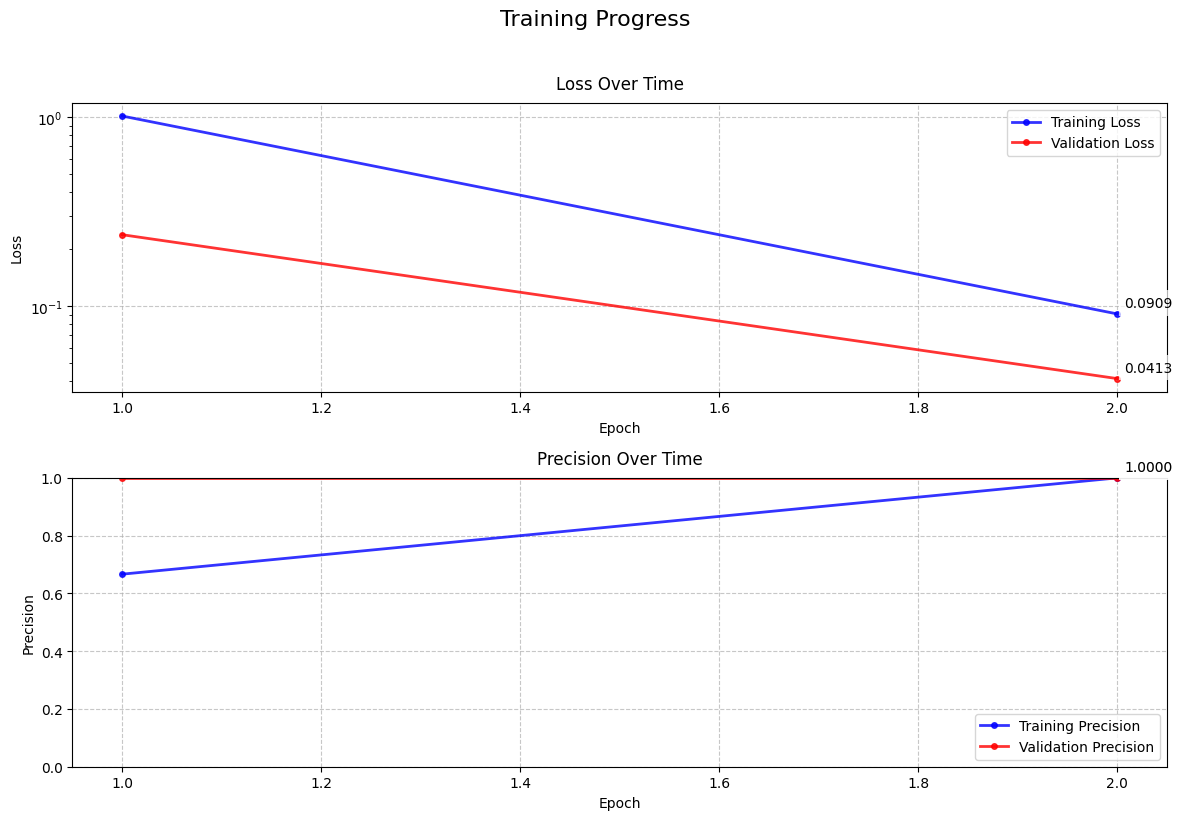

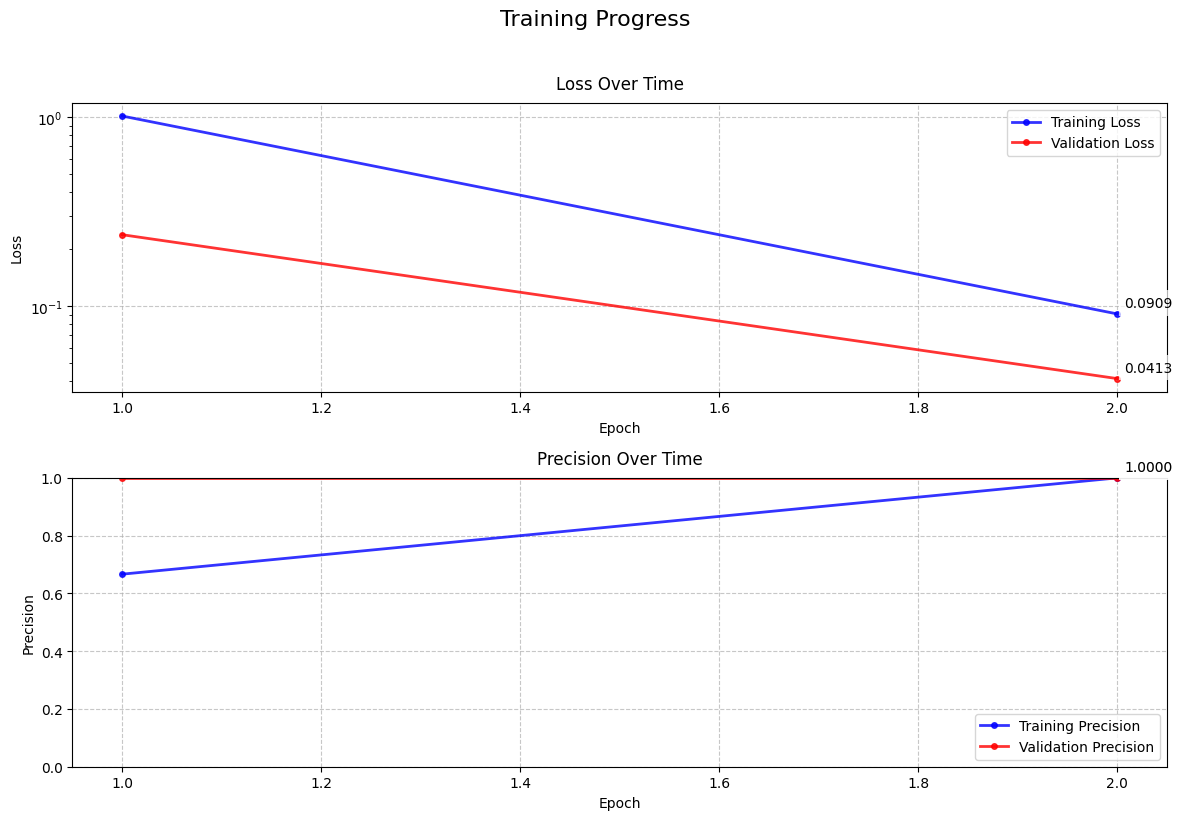

C:\Users\gcusumano\AppData\Local\Temp\ipykernel_43532\1304785127.py:17: SyntaxWarning: invalid escape sequence '\e'
  shutil.rmtree("exps\exp1")


KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

In [23]:
N_EPOCHS = 10
MAX_PATIENCE = 5
LEARNING_RATE = 1e-3
LR_DECAY = 0.99
DECAY_LR_EVERY_N_EPOCHS = 2
EXPERIMENT_NAME = 'exp1'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = vgg.to(device)
criterion = nn.CrossEntropyLoss().to(device)
logger = get_logger(ch_log_level=logging.INFO, fh_log_level=logging.INFO)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

print('  + Number of params: {}'.format(
    sum([p.data.nelement() for p in model.parameters()])))
exp = Experiment(EXPERIMENT_NAME, "exps", logger)
shutil.rmtree("exps\exp1")
# Create New Experiment
exp.init()
monitor = ColabTrainingMonitor()
import time

for epoch in range(exp.epoch, exp.epoch+N_EPOCHS):
    since = time.time()

    ### Train ###
    trn_loss, trn_precision = train(model, trainloader, criterion, optimizer, epoch)
    logger.info('Epoch {:d}: Train - Loss: {:.4f}\tPrecision: {:.4f}'.format(
        epoch, trn_loss, trn_precision))    
    time_elapsed = time.time() - since  
    logger.info('Train Time {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    
    ### Test ###
    val_loss, val_precision = test(model, testloader, criterion, epoch)    
    logger.info('Val - Loss: {:.4f}, Precision: {:.4f}'.format(
        val_loss, val_precision))
    time_elapsed = time.time() - since  
    logger.info('Total Time {:.0f}m {:.0f}s\n'.format(
        time_elapsed // 60, time_elapsed % 60))

    monitor.update(
        epoch=epoch,
        train_loss=trn_loss,
        val_loss=val_loss,
        train_precision=trn_precision, 
        val_precision=val_precision     
    )

    ### Save Metrics ###
    exp.save_history('train', trn_loss, trn_precision)
    exp.save_history('val', val_loss, val_precision)
    
    ### Checkpoint ###    
    exp.save_weights(model, trn_loss, val_loss, trn_precision, val_precision)
    exp.save_optimizer(optimizer, val_loss)
    
    ## Early Stopping ##
    if (epoch - exp.best_val_loss_epoch) > MAX_PATIENCE:
        logger.info(f"Early stopping at epoch {epoch} since no better loss found since epoch {exp.best_val_loss_epoch}")
        break

    ### Adjust Lr ###
    adjust_learning_rate(LEARNING_RATE, LR_DECAY, optimizer, 
                         epoch, DECAY_LR_EVERY_N_EPOCHS)
    
    exp.epoch += 1

try:
    monitor.save(os.path.join(exp.history_dir, 'final_training_progress.png'))
    monitor.stop()
except:
    pass